In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("orvile/isles-2022-brain-stoke-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/isles-2022-brain-stoke-dataset


FLAIR shape: (281, 352, 352)
Resampled mask shape: (281, 352, 352)


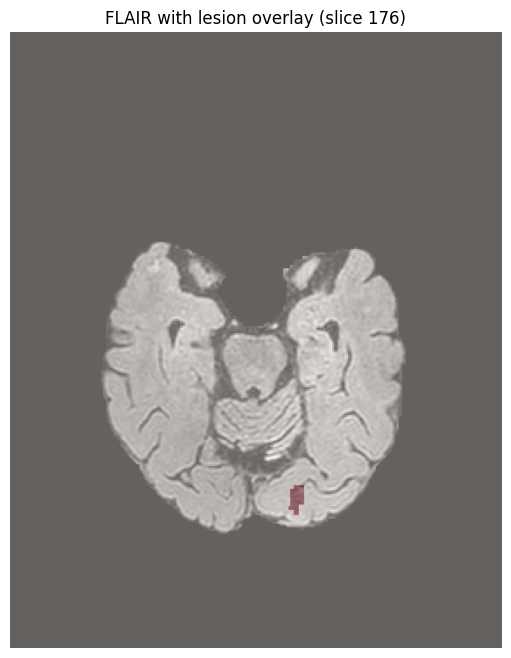

In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nibabel.processing import resample_from_to

# Load both images
mask_img = nib.load("/kaggle/input/isles-2022-brain-stoke-dataset/ISLES-2022/ISLES-2022/derivatives/sub-strokecase0001/ses-0001/sub-strokecase0001_ses-0001_msk.nii")
flair_img = nib.load("/kaggle/input/isles-2022-brain-stoke-dataset/ISLES-2022/ISLES-2022/sub-strokecase0001/ses-0001/anat/sub-strokecase0001_ses-0001_FLAIR.nii")

# Resample mask to FLAIR space
resampled_mask = resample_from_to(mask_img, flair_img, order=0)  # order=0 → nearest-neighbor (good for labels)

# Get data
flair_data = flair_img.get_fdata()
mask_data = resampled_mask.get_fdata()

print("FLAIR shape:", flair_data.shape)
print("Resampled mask shape:", mask_data.shape)

# Pick middle slice along axial axis
slice_idx = flair_data.shape[2] // 2
flair_slice = flair_data[:, :, slice_idx]
mask_slice = mask_data[:, :, slice_idx]

# Overlay
plt.figure(figsize=(8,8))
plt.imshow(flair_slice.T, cmap="gray", origin="lower")
plt.imshow(mask_slice.T, cmap="Reds", alpha=0.4, origin="lower")  # overlay with transparency
plt.title(f"FLAIR with lesion overlay (slice {slice_idx})")
plt.axis("off")
plt.show()


**Preprocessing**

Found 250 cases. Initializing generator...
Fetching and visualizing the first randomized batch...


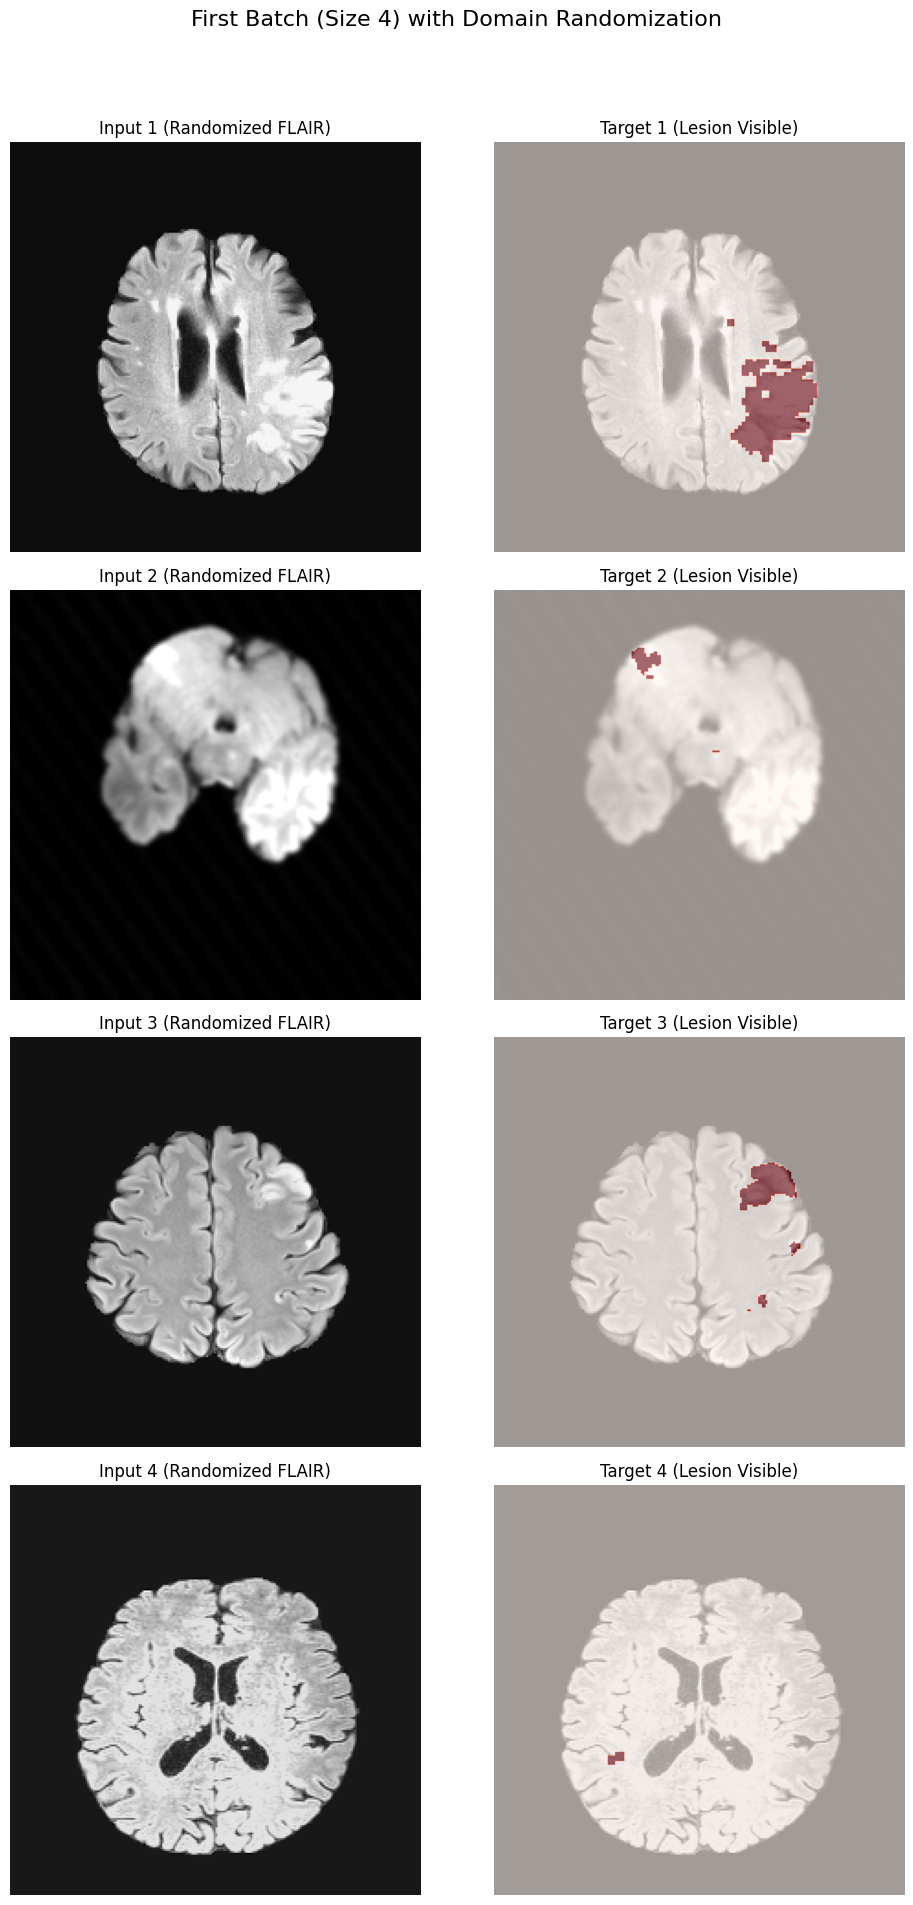

Batch shapes: Input (X): (4, 224, 224, 1), Target (Y): (4, 224, 224, 1)


In [36]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from nibabel.processing import resample_from_to
from tensorflow.keras.utils import Sequence
from scipy.ndimage import zoom, rotate, gaussian_filter, binary_dilation, binary_erosion
from scipy import fft

# --- Configuration Constants ---
BASE_DIR = "/kaggle/input/isles-2022-brain-stoke-dataset/ISLES-2022/ISLES-2022"
DERIVATIVES_DIR = os.path.join(BASE_DIR, "derivatives")
SESSION_ID = "ses-0001"
IMG_SIZE = (224, 224)
BATCH_SIZE = 4

# --- Helper Function for Resizing ---

def resize_slice(data, new_size, is_mask=False):
    """Resizes a 2D numpy array using scipy.ndimage.zoom."""
    current_h, current_w = data.shape
    target_h, target_w = new_size
    zoom_factors = (target_h / current_h, target_w / current_w)
    interpolation_order = 0 if is_mask else 3
    return zoom(data, zoom_factors, order=interpolation_order)

def match_shape(arr, ref_shape):
    """Ensures augmented image matches reference shape."""
    h, w = arr.shape
    ref_h, ref_w = ref_shape
    if (h, w) == (ref_h, ref_w):
        return arr
    zoom_factors = (ref_h / h, ref_w / w)
    return zoom(arr, zoom_factors, order=3)

# --- 1. Generator Class for NIfTI Domain Randomization ---

class KaggleNiftiGenerator(Sequence):
    """Keras Sequence for CPU-friendly 3D NIfTI data loading, resampling, and Domain Randomization (DR)."""
    def __init__(self, case_ids, base_dir, derivatives_dir, session_id, img_size, batch_size):
        self.case_ids = case_ids
        self.base_dir = base_dir
        self.derivatives_dir = derivatives_dir
        self.session_id = session_id
        self.img_size = img_size
        self.batch_size = batch_size
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.case_ids) / self.batch_size))

    def on_epoch_end(self):
        random.shuffle(self.case_ids)

    def _load_and_process_volume(self, case_id):
        """Loads, resamples, and extracts a 2D slice from one NIfTI pair."""
        flair_path = os.path.join(self.base_dir, case_id, self.session_id, "anat", f"{case_id}_{self.session_id}_FLAIR.nii")
        mask_path = os.path.join(self.derivatives_dir, case_id, self.session_id, f"{case_id}_{self.session_id}_msk.nii")

        flair_img = nib.load(flair_path)
        mask_img = nib.load(mask_path)
        resampled_mask = resample_from_to(mask_img, flair_img, order=0)

        flair_data = flair_img.get_fdata().astype(np.float32)
        mask_data = resampled_mask.get_fdata().astype(np.float32)

        flair_data = (flair_data - np.mean(flair_data)) / (np.std(flair_data) + 1e-6)
        flair_data = np.clip(flair_data, -3, 3) / 6.0 + 0.5
        min_val, max_val = flair_data.min(), flair_data.max()
        if max_val > min_val:
            flair_data = (flair_data - min_val) / (max_val - min_val)

        max_slice = flair_data.shape[2] - 1
        min_z = int(max_slice * 0.2)
        max_z = int(max_slice * 0.8)

        mask_sums = mask_data[:, :, min_z:max_z].sum(axis=(0, 1))
        lesion_slice_indices = np.where(mask_sums > 0)[0]

        if len(lesion_slice_indices) > 0:
            slice_idx = min_z + random.choice(lesion_slice_indices)
        else:
            slice_idx = random.randint(min_z, max_z)

        X_slice = flair_data[:, :, slice_idx]
        Y_slice = mask_data[:, :, slice_idx]
        X_slice = resize_slice(X_slice, self.img_size, is_mask=False)
        Y_slice = resize_slice(Y_slice, self.img_size, is_mask=True)

        return X_slice, Y_slice

    # --- 🔥 Full Domain Randomization Function ---
    def _apply_domain_randomization(self, img, mask):
        """Applies 2D image-level domain randomization on a slice."""
        ref_shape = img.shape
        X0, M0 = img.copy(), mask.copy()

        # --- 1) Contrast (image-only) ---
        if random.random() < 0.9:
            alpha = random.uniform(1.1, 1.4)
            beta = random.uniform(-0.1, 0.1)
            X0 = np.clip(X0 * alpha + beta, 0, 1)

        # --- 2) Noise (image-only) ---
        if random.random() < 0.9:
            noise_level = random.uniform(0.01, 0.03)
            X0 = np.clip(X0 + np.random.normal(0, noise_level, X0.shape), 0, 1)

        # --- 3) Flip (image + mask) ---
        if random.random() < 0.5:
            X0 = np.fliplr(X0)
            M0 = np.fliplr(M0)

        # --- 4) Rotation (image + mask) ---
        if random.random() < 0.7:
            angle = random.uniform(-10, 10)
            rotated = rotate(X0, angle, reshape=False, order=3, mode='nearest')
            rotated_mask = rotate(M0, angle, reshape=False, order=0, mode='nearest')
            X0 = match_shape(rotated, ref_shape)
            M0 = (match_shape(rotated_mask, ref_shape) > 0.5).astype(np.float32)

        # --- 5) Resolution degradation (image-only) ---
        if random.random() < 0.6:
            scale_factor = random.uniform(0.5, 0.8)
            lowres = zoom(X0, scale_factor, order=1)
            rescaled = zoom(lowres, 1.0 / scale_factor, order=3)
            X0 = np.clip(match_shape(rescaled, ref_shape), 0, 1)

        # --- 6) Morphological-like Intensity Perturbation (No Mask Leakage) ---
        if random.random() < 0.5:
            morph_type = random.choice(["Dilation", "Erosion"])
            
            # Create a pseudo-structure mask from intensity
            thresh = np.percentile(img, 60)  # mid-level threshold to define "tissue"
            pseudo_mask = (img > thresh).astype(np.float32)
            
            if morph_type == "Dilation":
                dilated = binary_dilation(pseudo_mask, iterations=2).astype(np.float32)
                ring = (dilated - pseudo_mask) > 0
                smooth_ring = gaussian_filter(ring.astype(np.float32), sigma=1.0)
                img = np.clip(img + 0.25 * smooth_ring, 0, 1)
                
            else:  # "Erosion"
                eroded = binary_erosion(pseudo_mask, iterations=2).astype(np.float32)
                ring = (pseudo_mask - eroded) > 0
                smooth_ring = gaussian_filter(ring.astype(np.float32), sigma=1.0)
                img = np.clip(img - 0.25 * smooth_ring, 0, 1)

        # --- 7) Blur (image-only) ---
        if random.random() < 0.6:
            sigma = random.uniform(1.0, 2.0)
            X0 = np.clip(match_shape(gaussian_filter(X0, sigma=sigma), ref_shape), 0, 1)

        # --- 8) FFT Spikes (image-only) ---
        if random.random() < 0.3:
            f = fft.fftshift(fft.fft2(X0))
            for _ in range(random.randint(1, 3)):
                x, y = random.randint(0, f.shape[0]-1), random.randint(0, f.shape[1]-1)
                f[x, y] *= random.uniform(3, 6)
            spikes = np.real(fft.ifft2(fft.ifftshift(f)))
            X0 = np.clip(match_shape(spikes, ref_shape), 0, 1)

        # --- 9) Bias field (image-only) ---
        if random.random() < 0.7:
            xx, yy = np.meshgrid(
                np.linspace(0, 1, ref_shape[0]),
                np.linspace(0, 1, ref_shape[1]),
                indexing='ij'
            )
            bias = 1 + 0.3 * np.sin(2 * np.pi * xx) * np.cos(2 * np.pi * yy)
            X0 = np.clip(X0 * bias, 0, 1)

        # --- Cleanup ---
        X0 = np.clip(X0, 0, 1)
        M0 = (M0 > 0).astype(np.float32)

        # Normalize to [0, 1]
        min_val, max_val = X0.min(), X0.max()
        if max_val > min_val:
            X0 = (X0 - min_val) / (max_val - min_val)

        return X0, M0

    # --- Batch Generation ---
    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size
        batch_case_ids = self.case_ids[start_idx:end_idx]

        X = np.empty((len(batch_case_ids), *self.img_size, 1), dtype=np.float32)
        Y = np.empty((len(batch_case_ids), *self.img_size, 1), dtype=np.float32)

        for i, case_id in enumerate(batch_case_ids):
            try:
                X_slice, Y_slice = self._load_and_process_volume(case_id)

                if random.random() < 0.8:  # 80% chance to apply DR
                    X_slice, Y_slice = self._apply_domain_randomization(X_slice, Y_slice)

                X[i, :, :, 0] = X_slice
                Y[i, :, :, 0] = Y_slice

            except Exception as e:
                print(f"Error processing {case_id}: {type(e).__name__}: {e}. Replacing with blank data.")
                X[i, :, :, 0] = np.zeros(self.img_size)
                Y[i, :, :, 0] = np.zeros(self.img_size)

        return X, Y

# --- 2. Setup and Visualization ---

try:
    subject_cases = [d for d in os.listdir(BASE_DIR) if d.startswith("sub-strokecase")]
    if not subject_cases:
        print(f"Error: No subject folders found in {BASE_DIR}. Check paths.")
        exit()
except FileNotFoundError as e:
    print(f"Error accessing directory: {e}. Check mounting.")
    exit()

print(f"Found {len(subject_cases)} cases. Initializing generator...")

data_generator = KaggleNiftiGenerator(
    case_ids=subject_cases,
    base_dir=BASE_DIR,
    derivatives_dir=DERIVATIVES_DIR,
    session_id=SESSION_ID,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

print("Fetching and visualizing the first randomized batch...")
X_batch, Y_batch = data_generator[0]

fig, axes = plt.subplots(BATCH_SIZE, 2, figsize=(10, 5 * BATCH_SIZE))
fig.suptitle(f"First Batch (Size {BATCH_SIZE}) with Domain Randomization", fontsize=16)

for i in range(BATCH_SIZE):
    ax_img = axes[i, 0]
    ax_img.imshow(X_batch[i, :, :, 0].T, cmap="gray", origin="lower")
    ax_img.set_title(f"Input {i+1} (Randomized FLAIR)")
    ax_img.axis("off")

    ax_mask = axes[i, 1]
    ax_mask.imshow(X_batch[i, :, :, 0].T, cmap="gray", origin="lower")
    mask_to_plot = Y_batch[i, :, :, 0].T
    ax_mask.imshow(mask_to_plot, cmap="Reds", alpha=0.6, origin="lower")
    lesion_status = "Lesion Visible" if np.sum(mask_to_plot) > 0 else "No Lesion"
    ax_mask.set_title(f"Target {i+1} ({lesion_status})")
    ax_mask.axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print(f"Batch shapes: Input (X): {X_batch.shape}, Target (Y): {Y_batch.shape}")


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import random, copy
from scipy.ndimage import rotate, zoom, gaussian_filter, binary_dilation, binary_erosion
import numpy.fft as fft

def visualize_each_randomization_bigview_mask_only(generator, case_id):
    """
    3 columns x 10 rows visualization.
    - Col 1: augmented image (image-only augmentations)
    - Col 2: mask overlay (for morph: shows original contour (yellow) + morphed contour (green))
    - Col 3: difference map (for morph: mask-difference visualization, otherwise intensity diff)
    Morphological change is applied to MASK only (ground truth).
    """
    def match_shape(img, ref_shape):
        """Pad or crop img to match ref_shape (centered). Works for 2D arrays."""
        img = np.squeeze(img)
        h, w = img.shape
        H, W = ref_shape
        # pad/crop height
        if h < H:
            pad_top = (H - h)//2
            pad_bottom = H - h - pad_top
            img = np.pad(img, ((pad_top, pad_bottom), (0, 0)), mode='edge')
        elif h > H:
            start = (h - H)//2
            img = img[start:start+H, :]
        # pad/crop width
        if w < W:
            pad_left = (W - w)//2
            pad_right = W - w - pad_left
            img = np.pad(img, ((0, 0), (pad_left, pad_right)), mode='edge')
        elif w > W:
            start = (w - W)//2
            img = img[:, start:start+W]
        return img

    # Load
    X0, M0 = generator._load_and_process_volume(case_id)
    X0 = np.clip(X0, 0, 1)
    M0 = (M0 > 0.5).astype(np.float32)
    ref_shape = X0.shape

    stages = []
    stage_masks = []
    titles = []

    # 1) Contrast (image-only)
    alpha, beta = 1.3, 0.1
    stages.append(np.clip(X0 * alpha + beta, 0, 1)); stage_masks.append(M0.copy()); titles.append(f"Contrast α={alpha}, β={beta}")

    # 2) Noise (image-only)
    noise_level = 0.02
    stages.append(np.clip(X0 + np.random.normal(0, noise_level, X0.shape), 0, 1)); stage_masks.append(M0.copy()); titles.append(f"Noise σ={noise_level}")

    # 3) Flip (image+mask must flip)
    flipped = np.fliplr(X0)
    flipped_mask = np.fliplr(M0)
    stages.append(flipped); stage_masks.append(flipped_mask); titles.append("Flip L↔R")

    # 4) Rotation (image+mask)
    angle = 10
    rotated = rotate(X0, angle, reshape=False, order=3, mode='nearest')
    rotated_mask = rotate(M0, angle, reshape=False, order=0, mode='nearest')
    rotated = match_shape(rotated, ref_shape)
    rotated_mask = (rotated_mask > 0.5).astype(np.float32)
    stages.append(np.clip(rotated, 0, 1)); stage_masks.append(rotated_mask); titles.append(f"Rotation {angle}°")

    # 5) Resolution degradation (image-only)
    scale_factor = 0.6
    lowres = zoom(X0, scale_factor, order=1)
    rescaled = zoom(lowres, 1.0 / scale_factor, order=3)
    rescaled = match_shape(rescaled, ref_shape)
    stages.append(np.clip(rescaled, 0, 1)); stage_masks.append(M0.copy()); titles.append(f"Resolution {scale_factor}x")

    # 6) Morphological change (MASK ONLY) — **this is the row you cared about**
    # --- 6) Morphological change on IMAGE ONLY (mask remains ground-truth) ---
    morph_type = random.choice(["Dilation", "Erosion"])
    
    # --- Create a pseudo-mask from the image intensity ---
    # Using a percentile threshold so it adapts to each image
    thresh = np.percentile(X0, 60)
    pseudo_mask = (X0 > thresh).astype(np.float32)

    img_morph = X0.copy()

    if morph_type == "Dilation":
        # Make a dilated pseudo-mask and compute the "added" ring
        dilated = binary_dilation(pseudo_mask, iterations=2).astype(np.float32)
        ring = (dilated - pseudo_mask) > 0
        smooth_ring = gaussian_filter(ring.astype(np.float32), sigma=1.0)
        # Brighten the ring region slightly
        img_morph = np.clip(img_morph + 0.25 * smooth_ring, 0, 1)

    else:  # "Erosion"
        # Make an eroded pseudo-mask and compute the "removed" ring
        eroded = binary_erosion(pseudo_mask, iterations=2).astype(np.float32)
        ring = (pseudo_mask - eroded) > 0
        smooth_ring = gaussian_filter(ring.astype(np.float32), sigma=1.0)
        # Darken the ring region slightly
        img_morph = np.clip(img_morph - 0.25 * smooth_ring, 0, 1)

    # Keep the original ground-truth mask unchanged
    stages.append(img_morph)
    stage_masks.append(M0.copy())
    titles.append(f"Morph (pseudo-mask): {morph_type}")


    # 7) Blur (image-only)
    sigma = 1.5
    blurred = gaussian_filter(X0, sigma=sigma)
    blurred = match_shape(blurred, ref_shape)
    stages.append(np.clip(blurred, 0, 1)); stage_masks.append(M0.copy()); titles.append(f"Blur σ={sigma}")

    # 8) FFT Spikes (image-only)
    f = fft.fftshift(fft.fft2(X0))
    for _ in range(3):
        x, y = random.randint(0, f.shape[0]-1), random.randint(0, f.shape[1]-1)
        f[x, y] *= 5
    spikes = np.real(fft.ifft2(fft.ifftshift(f)))
    spikes = match_shape(spikes, ref_shape)
    stages.append(np.clip(spikes, 0, 1)); stage_masks.append(M0.copy()); titles.append("FFT Spikes")

    # 9) Bias field (image-only)
    xx, yy = np.meshgrid(np.linspace(0,1,ref_shape[0]), np.linspace(0,1,ref_shape[1]), indexing='ij')
    bias = 1 + 0.3*np.sin(2*np.pi*xx)*np.cos(2*np.pi*yy)
    biased = np.clip(X0 * bias, 0, 1)
    biased = match_shape(biased, ref_shape)
    stages.append(biased); stage_masks.append(M0.copy()); titles.append("Bias Field")

    # 10) Combined (image-only)
    combined = np.clip(stages[1] + 0.1*bias - 0.05, 0, 1)  # noisy + slight bias
    combined = match_shape(combined, ref_shape)
    stages.append(combined); stage_masks.append(M0.copy()); titles.append("Combined Effects")

    # find index of morph row (used below)
    morph_index = None
    for idx, t in enumerate(titles):
        if t.startswith("Morph:"):
            morph_index = idx
            break

    # --- Visualization: 3 columns x 10 rows ---
    n = len(stages)
    fig, axes = plt.subplots(nrows=n, ncols=3, figsize=(10, 3*n))
    fig.suptitle(f"Randomization stages for {case_id} (mask-only morph shown)", fontsize=14)

    for i in range(n):
        img_i = match_shape(stages[i], ref_shape)
        mask_i = match_shape(stage_masks[i], ref_shape)

        # Column 1: Augmented image
        axes[i, 0].imshow(img_i.T, cmap='gray', origin='lower')
        axes[i, 0].set_title(titles[i], fontsize=10)
        axes[i, 0].axis('off')

        # Column 2: Overlay
        axes[i, 1].imshow(img_i.T, cmap='gray', origin='lower')
        # if this is the morph row, draw BOTH original contour (yellow) and morphed contour (green)
        if i == morph_index:
            axes[i, 1].imshow(mask_i.T, cmap='Reds', alpha=0.35, origin='lower')        # morphed fill
            axes[i, 1].contour(M0.T, levels=[0.5], colors='yellow', linewidths=0.8, origin='lower')  # original contour
            axes[i, 1].contour(mask_i.T, levels=[0.5], colors='lime', linewidths=0.9, origin='lower') # morphed contour
            # compute Dice and show in overlay title
            inter = np.sum((M0 > 0.5) & (mask_i > 0.5))
            dice = (2.0 * inter) / (np.sum(M0 > 0.5) + np.sum(mask_i > 0.5) + 1e-8)
            axes[i, 1].set_title(f"Mask overlay — Dice={dice:.3f}", fontsize=9)
        else:
            axes[i, 1].imshow(mask_i.T, cmap='Reds', alpha=0.35, origin='lower')
            axes[i, 1].contour(mask_i.T, levels=[0.5], colors='yellow', linewidths=0.6, origin='lower')
            axes[i, 1].set_title("Mask overlay", fontsize=9)
        axes[i, 1].axis('off')

        # Column 3: Difference map
        if i == morph_index:
            # show mask difference: green = added, red = removed, white = unchanged
            added = (mask_i == 1) & (M0 == 0)
            removed = (mask_i == 0) & (M0 == 1)
            H, W = ref_shape
            rgb = np.ones((H, W, 3), dtype=np.float32)  # white background
            rgb[added, :] = np.array([0.0, 1.0, 0.0])   # green for added
            rgb[removed, :] = np.array([1.0, 0.0, 0.0])  # red for removed
            axes[i, 2].imshow(np.transpose(rgb, (1, 0, 2)), origin='lower')
            axes[i, 2].set_title(f"Mask diff (added green, removed red)\nDice={dice:.3f}", fontsize=9)
            axes[i, 2].axis('off')
        else:
            # intensity difference vs original
            diff = img_i - X0
            mad = np.mean(np.abs(diff))
            vmax = np.percentile(np.abs(diff), 99) + 1e-6
            im = axes[i, 2].imshow(diff.T, cmap='bwr', vmin=-vmax, vmax=vmax, origin='lower')
            axes[i, 2].set_title(f"Diff (MAD={mad:.4f})", fontsize=9)
            axes[i, 2].axis('off')
            plt.colorbar(im, ax=axes[i, 2], fraction=0.046, pad=0.02)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


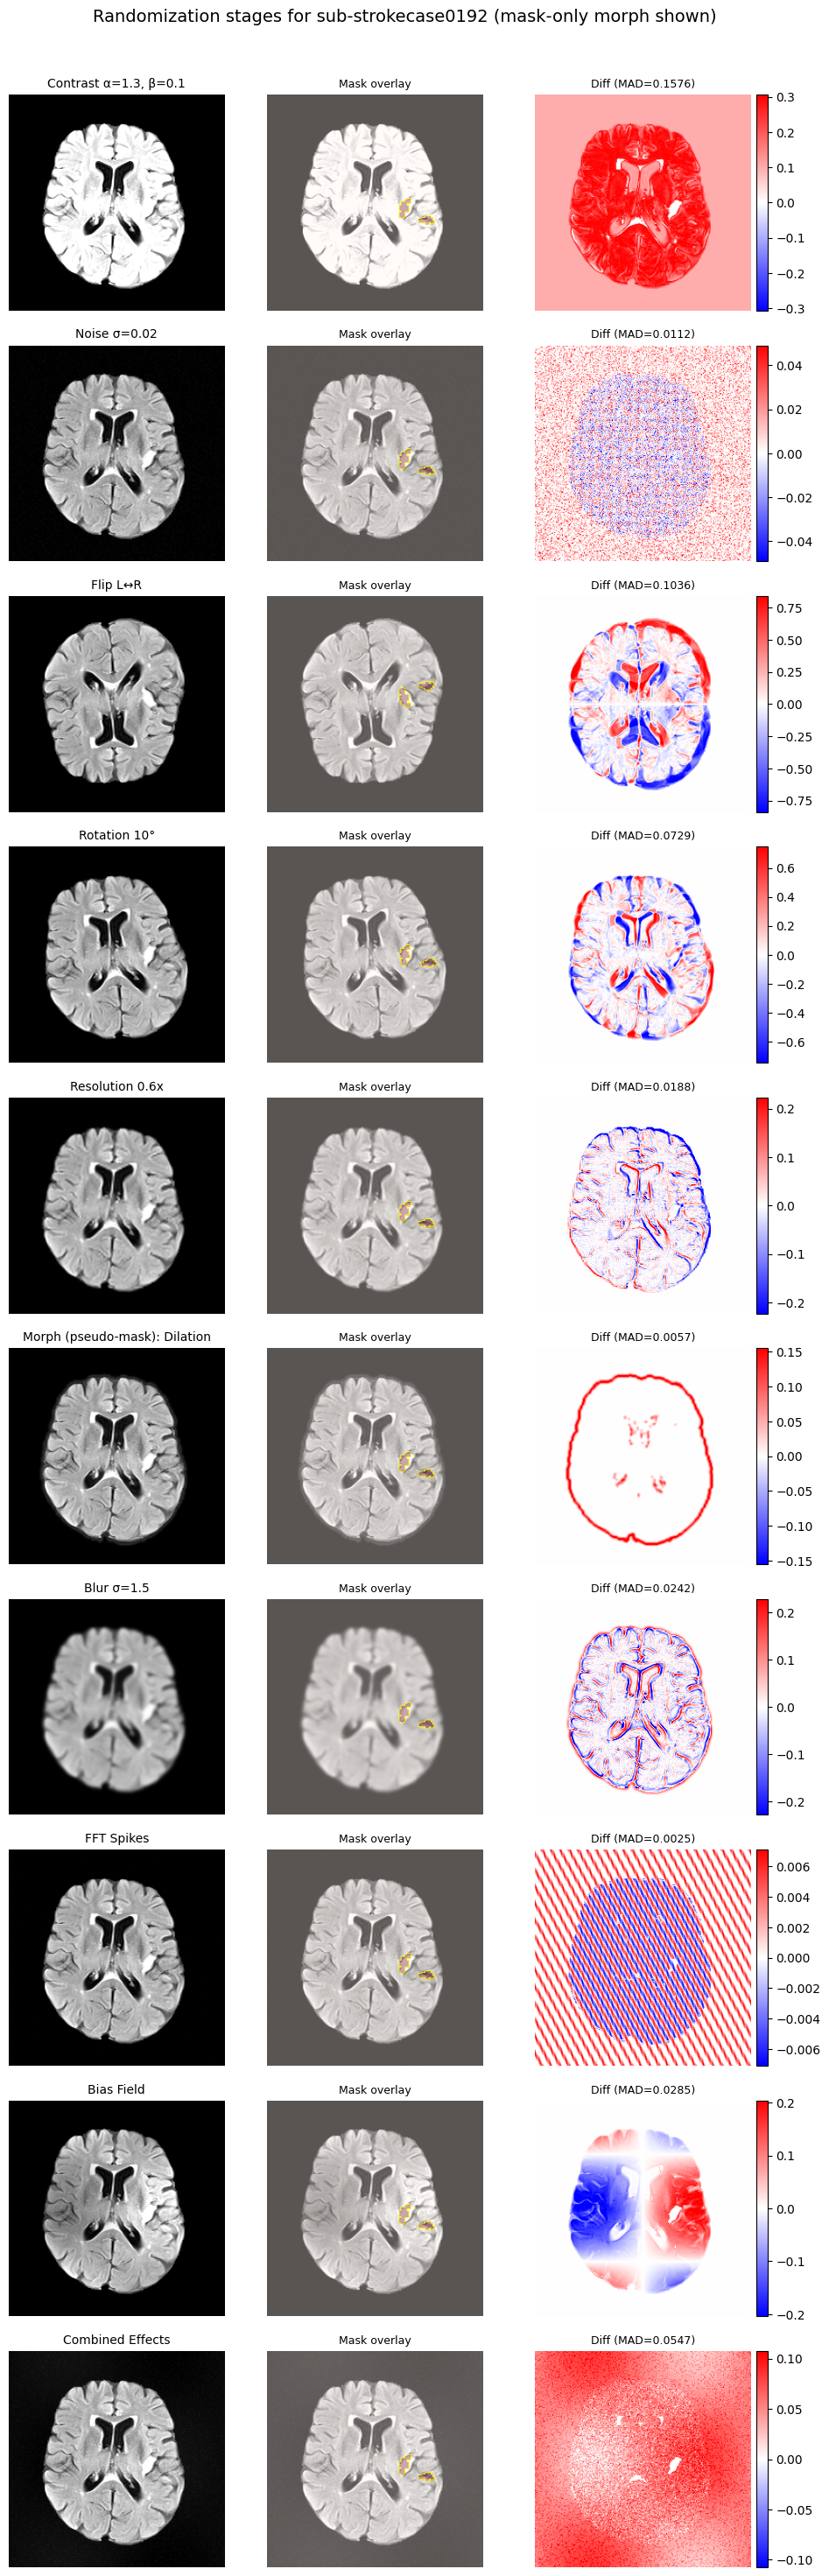

In [39]:
random_case = random.choice(subject_cases)
visualize_each_randomization_bigview_mask_only(data_generator, random_case)


* Add other modality

**Training**

* CPU friendly
* 2.5D model
* lightweight (~8–10MB after quantization) model
* 4–8 batch

In [ ]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="mobilenet_v2",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1,
)
